In [1]:
import sys
sys.path.append('/home/anna/annaCode/UiO/MEK4420/Oblig2_work')
from oblig2 import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

In [2]:
def parse_matlab_output(file_path):
    num_lines = sum(1 for line in open(file_path))

    x_m = np.empty(num_lines)
    y_m = np.empty(num_lines)
    x_p = np.empty(num_lines)
    y_p = np.empty(num_lines)
    
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            data = line.split()
            x_m[i] = float(data[0])  
            y_m[i] = float(data[1])  
            x_p[i] = float(data[2])  
            y_p[i] = float(data[3])  
    return x_m, y_m, x_p, y_p, num_lines

In [3]:
def integrate_with_radiation(file_path, nu, K_D_string, L_D_string):
    #nu=1.7 # k (wavenumber)
    x_m, y_m, x_p, y_p,  nn_total_segments = parse_matlab_output(file_path)
    #sgement_inddex =np.linspace(1,nn_total_segments,nn_total_segments)
    
    dx_array=x_p - x_m
    dy_array=y_p - y_m   
    
    #.^2 element wise squaring in matlab
    ds = ((dx_array)**2+(dy_array)**2)**(1/2)
    # bx and by are midpoints
    bx = 0.5*(x_m + x_p)
    by = 0.5*(y_m + y_p)
    n1 = -(y_p - y_m)/ds
    n2 = (x_p - x_m)/ds
    
    
    #points for Gauss integration on each segment
    xg1 = -0.5 * dx_array/np.sqrt(3)+bx
    xg2 = 0.5  * dx_array/np.sqrt(3)+bx
    yg1 = -0.5 * dy_array/np.sqrt(3)+by
    yg2 = 0.5  * dy_array/np.sqrt(3)+by
    
    phi0 = np.exp(nu*(by- complex(0, 1) * bx))
    phi0n = nu * (n2 - complex(0,1) * n1)* phi0
    
    gg = np.zeros([nn_total_segments,nn_total_segments], dtype=complex)
    ss = np.zeros([nn_total_segments,nn_total_segments], dtype=complex)
    ss_radiation = np.zeros([nn_total_segments,nn_total_segments], dtype=complex)
    
    for i in range(0,nn_total_segments):
        for j in range(0, nn_total_segments):
        #rhs, log(r) term with 2pts Gauss quadrature
            xa1 = xg1[j] - bx[i]
            xa2 = xg2[j] - bx[i]
            ya1 = yg1[j] - by[i]
            ya2 = yg2[j] - by[i]
            ra1 = np.sqrt(xa1*xa1+ya1*ya1)
            ra2 = np.sqrt(xa2*xa2+ya2*ya2)
            g0 = (np.log(ra1) + np.log(ra2))*0.5
            #% all other terms with midpoint rule
            xa = bx[j] - bx[i]
            yb = by[j] + by[i]
            rb = np.sqrt(xa*xa+yb*yb)
            g1 = -np.log(rb)
            zz = nu*(yb-complex(0,1)*xa)
            # expint exponential integral function
            f1 = -2*np.exp(zz)*(scipy.special.exp1(zz)+np.log(zz)-np.log(-zz))
            f2 = 2*np.pi*np.exp(zz)
            g2 = np.real(f1)+complex(0,1)*np.real(f2)
            gg[i,j] = (g0+g1+g2)*ds[j]
            #lhs
            arg0 = np.imag(np.log((x_m[j]-bx[i]+complex(0,1)*(y_m[j]- by[i]))/(x_p[j]-bx[i]+complex(0,1)*(y_p[j]-by[i]))))
            if j-i == 0:
                arg0 =np.pi
            arg1 = np.imag(np.log((x_m[j]-bx[i]+complex(0,1)*(y_m[j]+by[i]))/(x_p[j]-bx[i]+complex(0,1)*(y_p[j]+by[i]))))
            help1 = (n1[j]* (np.imag(f1)+complex(0,1)*np.imag(f2)) +n2[j]* (np.real(f1)+complex(0,1)*np.real(f2)))*nu*ds[j]
            ss[i,j]=(arg0+arg1+help1)
            # radiation problem
            arg0_radiation = np.imag(np.log((x_m[j]-bx[i]+complex(0,1)*(y_m[j]- by[i]))/(x_p[j]-bx[i]+complex(0,1)*(y_p[j]-by[i]))))
            if j-i == 0:
                arg0_radiation = -np.pi
            arg1_radiation = np.imag(np.log((x_m[j]-bx[i]+complex(0,1)*(y_m[j]+by[i]))/(x_p[j]-bx[i]+complex(0,1)*(y_p[j]+by[i]))))
            help1_radiation = (n1[j]* (np.imag(f1)+complex(0,1)*np.imag(f2)) +n2[j]* (np.real(f1)+complex(0,1)*np.real(f2)))*nu*ds[j]
            ss_radiation[i,j] = (arg0_radiation + arg1_radiation + help1_radiation)
            
    
    rhs = np.dot(gg,phi0n)
    lhs = np.dot(ss,phi0)

    rhs_radiation = np.dot(gg,n2)
    phi_radiation = np.linalg.solve(ss_radiation, rhs_radiation)

    
    plot_integ_and_ration(lhs, rhs, phi_radiation, x_m, y_m, x_p, y_p,  K_D_string, L_D_string)
    
    return rhs, lhs, phi_radiation

In [4]:
def plot_integ_and_ration(lhs, rhs, phi_r, x_m, y_m, x_p, y_p,  K_D_string, L_D_string):
    
    nn_total_segments = len(rhs)
    segment_index =np.linspace(1,nn_total_segments,nn_total_segments)

    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    
    axs[0,0].plot(segment_index,np.imag(rhs), color = 'red', alpha = 0.5, label="im rhs")
    axs[0,0].scatter(segment_index,np.imag(lhs), color = 'black', alpha = 0.5, s=5,label= "im lhs")
    axs[0,0].plot(segment_index, np.real(rhs), alpha = 0.5, label="re rhs")
    axs[0,0].scatter(segment_index, np.real(lhs), s=5, label="re lhs")
    axs[0,0].set_title('error as a function of segment number (lecture notes)' +  K_D_string + ' ' +  L_D_string )
    axs[0,0].grid(True)
    axs[0,0].legend()
    axs[0,1].fill_between(segment_index,np.imag(rhs), np.imag(lhs), color = 'red', alpha = 0.5, label= "imaginary part")
    axs[0,1].fill_between(segment_index,np.real(rhs), np.real(lhs), color = 'blue', alpha = 0.5, label= "real part")
    axs[0,1].grid(True)
    axs[0,1].set_title('error as a function of segment number (error area)' +  K_D_string + ' ' + L_D_string)
    axs[0,1].legend()

    segment_index =np.linspace(1,nn_total_segments,nn_total_segments)
    axs[1,0].scatter(segment_index, np.imag(phi_r), color = 'red', alpha = 0.5, s=5,label= "Im(Φ_R)")
    axs[1,0].scatter(segment_index, np.real(phi_r), color = 'navy', s=5, label = "Re(Φ_R)")
    axs[1,0].set_title('Radiation pot. value for segement number ' +  K_D_string + ' ' +  L_D_string )
    axs[1,0].grid(True)
    axs[1,0].legend()

    mid_x = 0.5*(x_m + x_p)
    mid_y = 0.5*(y_m + y_p)
    
    axs[2,0].set_facecolor('lightgrey')
    sc =axs[2,0].scatter(mid_x, mid_y, c= np.real(phi_r), s = 10, cmap='hot')
    c_bar = fig.colorbar(sc)
    c_bar.set_label('color map/ radiation potential ')
    axs[2,0].set_title('Re(Φ_R) at boundary midpoints' +  K_D_string + ' ' +  L_D_string )
    norm1 = sc.norm

    axs[2,1].set_facecolor('lightgrey')
    sc2 =axs[2,1].scatter(mid_x, mid_y, c= np.imag(phi_r), s = 10, cmap=sc.get_cmap(), norm=norm1)
    c_bar2 = fig.colorbar(sc2)
    c_bar2.set_label('color map/ radiation potential ')
    axs[2,1].set_title('Im(Φ_R) at boundary midpoints' +  K_D_string + ' ' +  L_D_string )
 
 

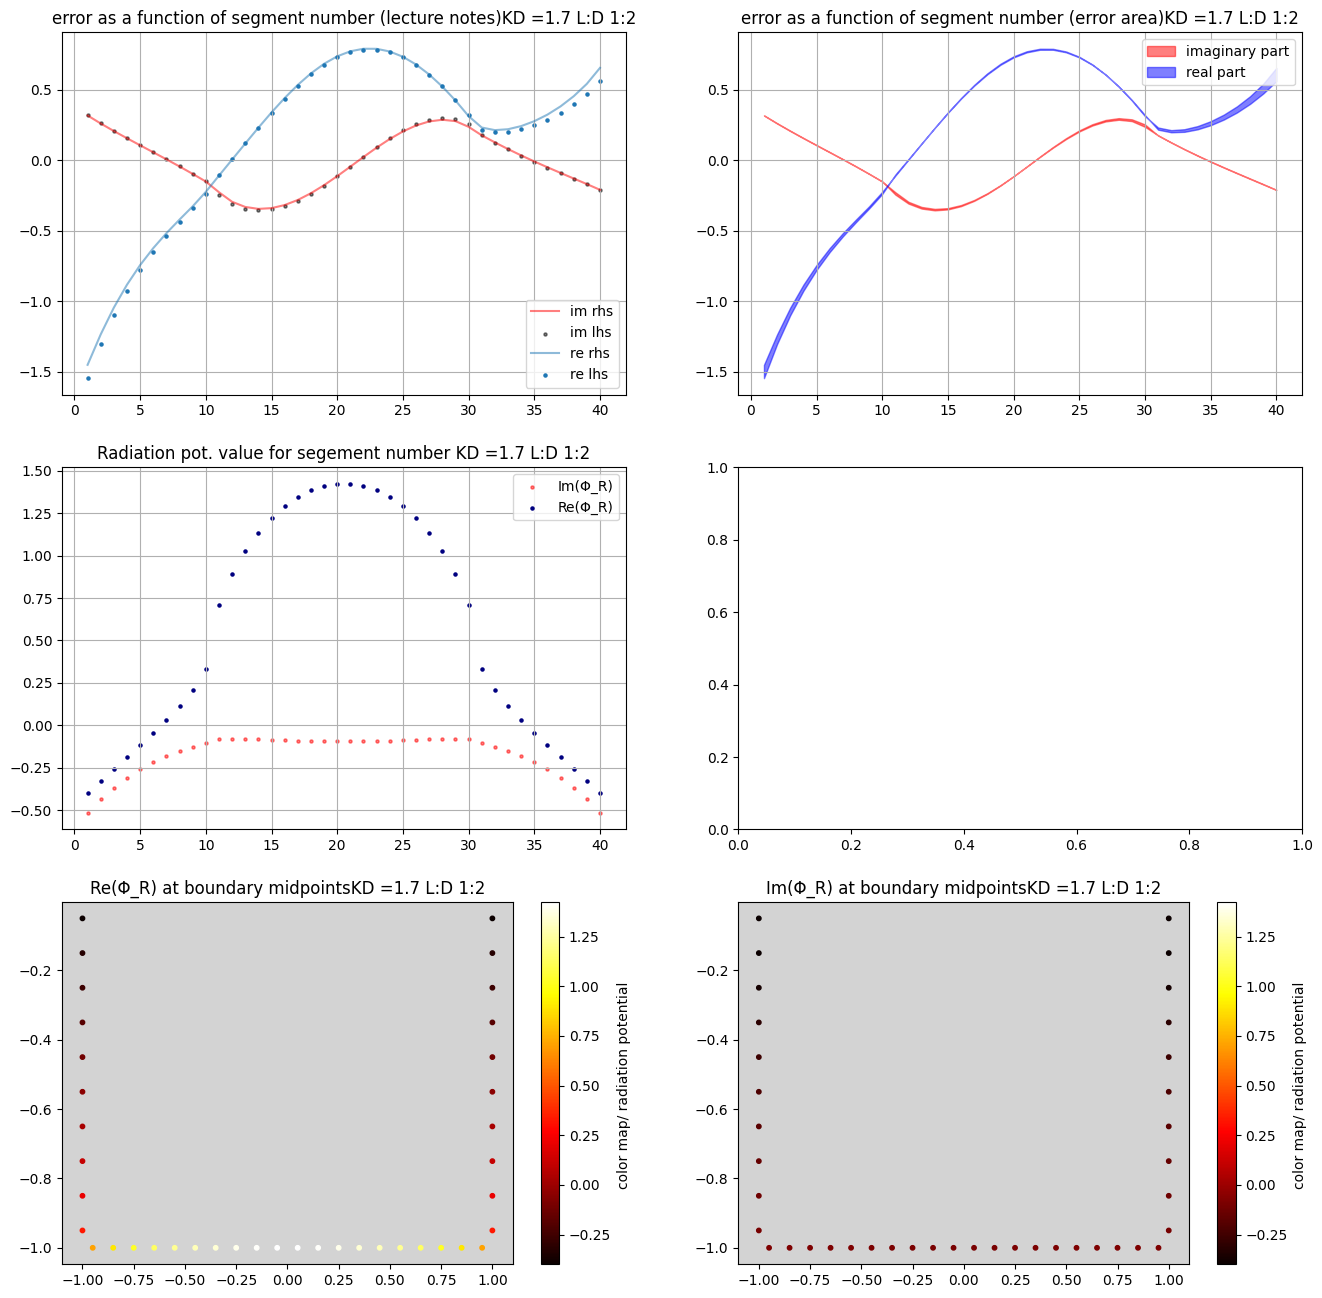

In [5]:
#file_path = '/home/anna/MATLAB/R2023b/bin/box.dat'
#box1_0.1.dat  box1_10.dat  box1_1.dat  box1_2.dat  box.dat

file_path = '/home/anna/annaCode/UiO/MEK4420/Oblig2_work/box.dat'
#KD = 1.2 since D is 1 then K is 1
k = 1.7
L_D_string = "L:D 1:2"
K_D_string = f"KD ={k}" 
lhs, rhs, phi_r =  integrate_with_radiation(file_path, k, K_D_string, L_D_string)